# <center>Using Deep Learning to Generate Synthetic Instrumental Variables </center>
## <center>Berkay Akyapi</center>

The following line of codes show a way to generate a synthetic IV. First, I show that with the right condition this works. Later, I provide some explanations on why some other things don't work. Please contact me from berkayakyapi@ufl.edu if you have a solution to this problem.

In [2]:
# Load packages we need
import sys
import os

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import statsmodels.api as sm

import tensorflow as tf

# we'll use keras for neural networks
import tensorflow.keras as keras

from sklearn.linear_model import LinearRegression


import keras.backend as K
# import layers we will use
from tensorflow.keras.layers import Input, Dense
from keras.layers import LeakyReLU

# import callbacks we will use
from keras.callbacks import EarlyStopping, ModelCheckpoint

# %matplotlib inline
from matplotlib import pyplot as plt

# Let's check our software versions
print('### Python version: ' + sys.version) #3.8.8
print('### Numpy version: ' + np.__version__) # 1.21.5
print('### Scikit-learn version: ' + sklearn.__version__) #1.0.2
print('### Tensorflow version: ' + tf.__version__) # 2.6.0
print('------------')

### Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
### Numpy version: 1.21.5
### Scikit-learn version: 1.0.2
### Tensorflow version: 2.6.0
------------


In [3]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 32

np.random.seed(seed) # deterministic seed for reproducibility

tf.random.set_seed(seed)


<h2>Instrumental Variable (IV) Approach<h2>

I simulate 3 vectors ($x_1, x_2, x_3$) from a multinomial distribution. The variance-covariance matrix, $\Sigma$, has the following form:

\begin{equation*}
\Sigma = 
\begin{pmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{13} \\
\sigma_{21} & \sigma_{22} & \sigma_{23} \\
\sigma_{31} & \sigma_{32} & \sigma_{33}
\end{pmatrix}
= 
\begin{pmatrix}
3 & 2 & 0 \\
2 & 4 & -3 \\
0 & -3 & 4
\end{pmatrix}
\end{equation*}

#### Note that $x_1$ and $x_2$ are correlated and $x_2$ and $x_3$ are correlated. However, $x_1$ and $x_3$ are not correlated. We want to do a similar thing to this, but through deep learning.

### $y = \alpha_0 + \alpha_1x_1 + \alpha_2x_2 + \varepsilon$

In [4]:
samples = 16384
Sigma = np.array([[3,2,0], [2,4,1],[0,1,4]])
x_1,x_2, x_3 = np.random.multivariate_normal([0,0,0],Sigma, samples).T
err = np.random.normal(0,1,samples)

alpha_0 = 2
alpha_1 = 11
alpha_2 = -4

y = alpha_0 + alpha_1*x_1 + alpha_2*x_2 + err

### With no omitted variables, we can get unbiased estimates of the coefficients.

In [5]:
X = np.array([x_1, x_2]).T

reg = LinearRegression().fit(X,y)
print('We estimeate:             alpha_1 = {:.1f}, alpha_2 = {:.1f}'.format(reg.coef_[0], reg.coef_[1]))

print('\nOriginal coefficients are alpha_1 = {}, alpha_2 = {}'.format(alpha_1, alpha_2))


We estimeate:             alpha_1 = 11.0, alpha_2 = -4.0

Original coefficients are alpha_1 = 11, alpha_2 = -4


### Assume we are only interested in the coefficient of $x_2$. 

#### When we exclude $x_1$ we have a biased coefficient for $x_2$ because $E[x_2x_1] \neq 0$. As their correlation is positive and the coefficient of the omitted variable is positive, the estimated coefficient for $x_2$ will bigger than the original coefficient.

In [6]:
X_no_x1 = np.array([x_2]).T
reg = LinearRegression().fit(X_no_x1,y)
print('We estimate:             alpha_2 = {:.2f}'.format(reg.coef_[0]))

print('\n Original coefficients are alpha_2 = {} '.format(alpha_2))


We estimate:             alpha_2 = 1.48

 Original coefficients are alpha_2 = -4 


### Next we will use $x_3$ as an IV for $x_2$. We need a variable that is correlated with $x_2$ and not correlated with the error term (which is $\alpha_1x_1 + \varepsilon$ when we do not include $x_1$ into the regressions) to have a working instrument. Note that $x_3$ satisfies this. 

The next cell estimates $x_2$ with $x_3$ as follows: 
1. First we estimate the coefficient from $x_2 = \theta x_3 + \varepsilon$ and get $\hat{\theta}$
2. Next, we calculate $\hat{x_2}=\hat{\theta}x_3$

In [7]:
#1.
reg = LinearRegression().fit(x_3.reshape(-1,1),x_2.reshape(-1,1))
#2.
x_2_hat = reg.predict(x_3.reshape(-1,1)).reshape(-1,)

### Now we will have an unbiased estimator:

In [8]:
X_no_x1_butx2_hat = np.array([x_2_hat]).T
reg = LinearRegression().fit(X_no_x1_butx2_hat,y)
print('We estimate:             alpha_2 = {:.2f}'.format(reg.coef_[0]))

# Keep the following line for comparison
print('\n Original coefficients are alpha_2 = {} '.format(alpha_2))


We estimate:             alpha_2 = -4.00

 Original coefficients are alpha_2 = -4 


### We can see that our estimate is statistically significant

In [9]:
XX = np.ones([samples, np.shape(X_no_x1_butx2_hat)[1]+1])
XX[:,0] = 1
XX[:,1:] = X_no_x1_butx2_hat.copy()
model = sm.OLS(y, XX) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     247.7
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           2.15e-55
Time:                        15:42:01   Log-Likelihood:                -68529.
No. Observations:               16384   AIC:                         1.371e+05
Df Residuals:                   16382   BIC:                         1.371e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0855      0.124     16.829      0.0

<h2>Deep Learning Architecture<h2>

## Architecture:
We use 4 hidden layers. The first 3 of them have ELU as activation function (https://keras.io/api/layers/activation_layers/elu/) and the last hidden layer has a linear activation function

In [10]:
def create_model(input_shape):  
    
    model = keras.models.Sequential(name = 'IVGEN')
    
    # Input Layer
    model.add(keras.Input(input_shape, name = 'Input')) 
    
    # Hidden Layers
    #1
    model.add(keras.layers.Dense(24, name = 'theElu_Dense_1'))
    model.add(keras.layers.ELU(alpha=1, name = 'theElu_1'))
    #2
    model.add(keras.layers.Dense(18, name = 'theElu_Dense_2'))
    model.add(keras.layers.ELU(alpha=1, name = 'theElu_2'))
    #3
    model.add(keras.layers.Dense(12, name = 'theElu_Dense_3'))
    model.add(keras.layers.ELU(alpha=1, name = 'theElu_3'))
    #4
    model.add(keras.layers.Dense(6, activation='linear', name = 'linear_1'))
    
    # Output Layer
    model.add(keras.layers.Dense(1, activation='linear', name = 'Output'))
    
    return model

## The aim is to generate a new variable such that it is correlated with $x_2$ but uncorrelated with $x_1$. The aim of this exercise is to show that we can generate a synthetic IV using the right conditions.

<h2>Syntetic IV<h2>

### Custom Loss Function: This function has 3 inputs: err (=x_1), y_true and y_pred. y_pred is the value to be generated through the inputs. We want y_pred to be correlated with y_true but uncorrelated with err. 

#### We want big:
\begin{equation*}
r = \frac{\sum[(prediction_i - \mu_{prediction})(x_{2i}-\mu_{x2})]}{\sqrt{\sum(prediction_i - \mu_{prediction})^2\sum(x_{2i}-\mu_{x2})^2}}
\end{equation*}
#### We want small:
\begin{equation*}
r2 = \frac{\sum[(prediction_i - \mu_{prediction})(x_{1i}-\mu_{x_1})]}{\sqrt{\sum(prediction_i - \mu_{prediction})^2\sum(x_{1i}-\mu_{x_1})^2}}
\end{equation*}

In [11]:
# Define custom loss
def custom_loss(the_y):
    temp = K.constant(the_y)
    # the_y = x_1

    def loss(y_true,y_pred):
        # y_true = x_2
        # y_pred is the output

        mx = K.mean(y_true)
        my = K.mean(y_pred)
        xm, ym = y_true-mx, y_pred-my
        r_num = K.sum(tf.multiply(xm,ym))        
        r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
        
        r = r_num / r_den
        
        r = K.abs(r) # We want big

  
        me = K.mean(temp)
        em = temp-me
        r2_num = K.sum(tf.multiply(em,ym))
        r2_den = K.sqrt(tf.multiply(K.sum(K.square(em)), K.sum(K.square(ym))))
        r2 = r2_num / r2_den
    
        r2 = K.abs(r2) # We want 0
        
        return r2 - r
   
    # Return a function
    return loss

### Generate the Input and Output:

In [12]:
# Input (to the architecture)
theShape = 32
myNoise = np.random.multivariate_normal(np.zeros((theShape,)),np.identity(theShape), samples)
# Input to Custom Loss
err = x_1.reshape(-1,1)
# Output
x2_shaped = x_2.reshape(-1,samples,1) 

### The input is just random noise.

In [13]:
model = create_model(myNoise.shape)
myNoise = myNoise.reshape(-1,samples,np.shape(myNoise)[1])
model.summary()

Model: "IVGEN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
theElu_Dense_1 (Dense)       (None, 16384, 24)         792       
_________________________________________________________________
theElu_1 (ELU)               (None, 16384, 24)         0         
_________________________________________________________________
theElu_Dense_2 (Dense)       (None, 16384, 18)         450       
_________________________________________________________________
theElu_2 (ELU)               (None, 16384, 18)         0         
_________________________________________________________________
theElu_Dense_3 (Dense)       (None, 16384, 12)         228       
_________________________________________________________________
theElu_3 (ELU)               (None, 16384, 12)         0         
_________________________________________________________________
linear_1 (Dense)             (None, 16384, 6)          78    

### We use a learning rate of .002 and Adam optimizer to train our architecture

In [15]:
lr = 0.002

opt = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=custom_loss(tf.convert_to_tensor(err, dtype=tf.float32)), optimizer= opt)

In [16]:
print('Shape of the output: ', np.shape(x2_shaped))
print('Shape of features:   ', np.shape(myNoise) )
print('Shape of loss input: ', np.shape(err))

Shape of the output:  (1, 16384, 1)
Shape of features:    (1, 16384, 32)
Shape of loss input:  (16384, 1)


## Learning:
Overfitting is not a problem for this example, hence we don't need validation or test datasets

In [17]:
# set up an early stopping callback
early_stop_cb = EarlyStopping(monitor='loss', patience=10, mode = 'min')

# set up a model checkpointing callback
fp = "./mymodel-bestweights_custom1.h5"
checkpoint_cb = ModelCheckpoint(fp, monitor='loss', save_best_only=True, mode='min')


history = model.fit(myNoise, x2_shaped, epochs=1000, callbacks=[early_stop_cb,checkpoint_cb])



Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: -0.0075
Epoch 2/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.0108
Epoch 3/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.0110
Epoch 4/1000
1/1 [==============================] - 0s 14ms/step - loss: -0.0130
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.0160
Epoch 6/1000
1/1 [==============================] - 0s 3ms/step - loss: -0.0163
Epoch 7/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.0170
Epoch 8/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.0179
Epoch 9/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.0191
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.0203
Epoch 11/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.0217
Epoch 12/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.0231
Epoch 13/1000
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: -0.1533
Epoch 102/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.1552
Epoch 103/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.1566
Epoch 104/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.1575
Epoch 105/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.1596
Epoch 106/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.1607
Epoch 107/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.1616
Epoch 108/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.1628
Epoch 109/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.1636
Epoch 110/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.1654
Epoch 111/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.1664
Epoch 112/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.1675
Epoch 113/1000
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: -0.2210
Epoch 201/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.2212
Epoch 202/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2215
Epoch 203/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.2210
Epoch 204/1000
1/1 [==============================] - 0s 3ms/step - loss: -0.2220
Epoch 205/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2229
Epoch 206/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.2227
Epoch 207/1000
1/1 [==============================] - 0s 2ms/step - loss: -0.2237
Epoch 208/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.2235
Epoch 209/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.2242
Epoch 210/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.2250
Epoch 211/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2249
Epoch 212/1000
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: -0.2537
Epoch 300/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2517
Epoch 301/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2540
Epoch 302/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2537
Epoch 303/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2539
Epoch 304/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2550
Epoch 305/1000
1/1 [==============================] - 0s 36ms/step - loss: -0.2529
Epoch 306/1000
1/1 [==============================] - 0s 18ms/step - loss: -0.2552
Epoch 307/1000
1/1 [==============================] - 0s 32ms/step - loss: -0.2550
Epoch 308/1000
1/1 [==============================] - 0s 45ms/step - loss: -0.2551
Epoch 309/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.2563
Epoch 310/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2540
Epoch 311/1000
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: -0.2709
Epoch 399/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.2732
Epoch 400/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.2731
Epoch 401/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2736
Epoch 402/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2738
Epoch 403/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2737
Epoch 404/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.2729
Epoch 405/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2739
Epoch 406/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.2743
Epoch 407/1000
1/1 [==============================] - 0s 22ms/step - loss: -0.2727
Epoch 408/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2747
Epoch 409/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.2735
Epoch 410/1000
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: -0.2872
Epoch 498/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2880
Epoch 499/1000
1/1 [==============================] - 0s 14ms/step - loss: -0.2867
Epoch 500/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.2878
Epoch 501/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2876
Epoch 502/1000
1/1 [==============================] - 0s 17ms/step - loss: -0.2878
Epoch 503/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2889
Epoch 504/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.2860
Epoch 505/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.2888
Epoch 506/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.2886
Epoch 507/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.2887
Epoch 508/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.2896
Epoch 509/1000
1/1 [====

1/1 [==============================] - 0s 9ms/step - loss: -0.2985
Epoch 597/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2960
Epoch 598/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2983
Epoch 599/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.2985
Epoch 600/1000
1/1 [==============================] - 0s 14ms/step - loss: -0.2965
Epoch 601/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.2993
Epoch 602/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2970
Epoch 603/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.2986
Epoch 604/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.2989
Epoch 605/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2986
Epoch 606/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2998
Epoch 607/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.2982
Epoch 608/1000
1/1 [===

1/1 [==============================] - 0s 9ms/step - loss: -0.3077
Epoch 696/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.3054
Epoch 697/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.3080
Epoch 698/1000
1/1 [==============================] - 0s 17ms/step - loss: -0.3066
Epoch 699/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.3075
Epoch 700/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.3079
Epoch 701/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.3073
Epoch 702/1000
1/1 [==============================] - 0s 19ms/step - loss: -0.3083
Epoch 703/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.3076
Epoch 704/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.3086
Epoch 705/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.3086
Epoch 706/1000
1/1 [==============================] - 0s 19ms/step - loss: -0.3066
Epoch 707/1000
1/1 [=======

1/1 [==============================] - 0s 8ms/step - loss: -0.3149
Epoch 795/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.3149
Epoch 796/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.3133
Epoch 797/1000
1/1 [==============================] - 0s 19ms/step - loss: -0.3151
Epoch 798/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.3140
Epoch 799/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.3147
Epoch 800/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.3151
Epoch 801/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.3148
Epoch 802/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.3153
Epoch 803/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.3151
Epoch 804/1000
1/1 [==============================] - 0s 36ms/step - loss: -0.3156
Epoch 805/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.3158
Epoch 806/1000
1/1 [===

In [18]:
loaded_model = tf.keras.models.load_model(fp, custom_objects={ 'loss': custom_loss(tf.convert_to_tensor(err, dtype=tf.float32))})

prediction = loaded_model.predict(myNoise).reshape(-1,)

np.shape(prediction)

(16384,)

In [19]:
np.corrcoef(prediction, x_2.reshape(-1,)) ## We want big (absolute value)

array([[1.        , 0.32202549],
       [0.32202549, 1.        ]])

In [20]:
np.corrcoef(prediction, x_1.reshape(-1,)) ## We want small

array([[1.        , 0.00229773],
       [0.00229773, 1.        ]])

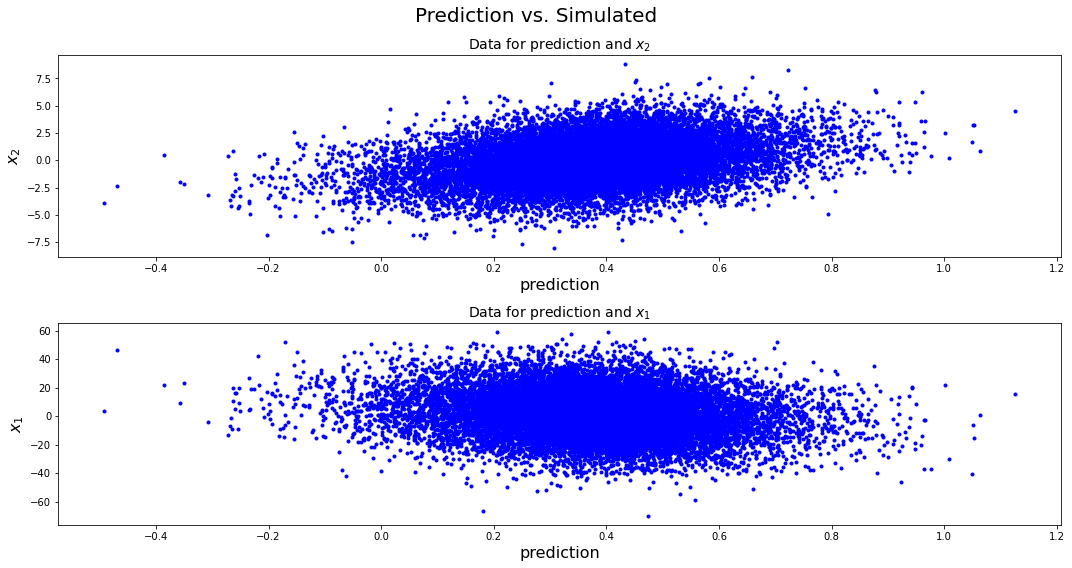

In [21]:
plt.rcParams['figure.figsize'] = [15, 8] # This is just to make the plots look bigger

fig, axs = plt.subplots(2)
fig.suptitle('Prediction vs. Simulated', fontsize = 20)
# Plotting pred and x2 (positive correlation)
axs[0].plot(prediction, x_2,'o', markersize=3, color = 'blue')
axs[0].set_xlabel('prediction', fontsize = 16)
axs[0].set_ylabel(r'$x_2$', fontsize = 16)
axs[0].set_title(r'Data for prediction and $x_2$', fontsize = 14)
# Plotting pred and y (Negative Correlation)
axs[1].plot(prediction, y,'o', markersize=3, color = 'blue')
axs[1].set_xlabel('prediction', fontsize = 16)
axs[1].set_ylabel(r'$x_1$', fontsize = 16)
axs[1].set_title(r'Data for prediction and $x_1$', fontsize = 14)

fig.tight_layout()
plt.show()

### Next exercises show that synthetic IV can be generated with the right conditions and we can solve the problem of endogeneity!

#### Using the Synthetic IV in 2SLS Regression:

In [22]:
reg = LinearRegression().fit(prediction.reshape(-1,1),x_2.reshape(-1,1))
x_2_hat = reg.predict(prediction.reshape(-1,1)).reshape(-1,)

In [23]:
X_no_x1_butx2_hat = np.array([x_2_hat]).T
reg = LinearRegression().fit(X_no_x1_butx2_hat,y)
print('We estimate:             alpha_2 = {:.2f}'.format(reg.coef_[0]))

# Keep the following line for comparison
print('\n Original coefficients are alpha_2 = {}'.format(alpha_2))


We estimate:             alpha_2 = -3.94

 Original coefficients are alpha_2 = -4


#### The coefficient is statistically significant and the true value is within the 95% confidence interval.

In [24]:
XX = np.ones([samples, np.shape(X_no_x1_butx2_hat)[1]+1])
XX[:,0] = 1
XX[:,1:] = X_no_x1_butx2_hat.copy()
model = sm.OLS(y, XX) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     427.2
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           1.02e-93
Time:                        15:46:33   Log-Likelihood:                -68441.
No. Observations:               16384   AIC:                         1.369e+05
Df Residuals:                   16382   BIC:                         1.369e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0859      0.123     16.924      0.0

### If we knew $x_1$ we could just include it to the regression. So the challenge is to find the correct condition to minimize the correlation with $x_1$, once we can come up with a conclusion we can solve the problem of endogeneity.

# Some of the things I tried so far:

# Using guesses:

### Here is some algebra showing why using guesses won't work

We guess $\hat{\alpha}_2$ and calculate $\hat{u} = y - \hat{\alpha}_2x_2 = \alpha_1x_1 + (\alpha_2- \hat{\alpha}_2)x_2$. Let $z$ denote the synthetic IV. We generate it such that $|E[z^Tx_2]| \approx 1 >0$ and 

\begin{equation}
E[z^T\hat{u}]= E[z^T(\alpha_1x_1 + (\alpha_2- \hat{\alpha}_2)x_2)]=0 \implies E[z^Tx_1]=-\frac{\alpha_2 - \hat{\alpha}_2}{\alpha_1}E[z^Tx_2]
\end{equation}

In the first stage we calculate $\hat{x_2} = \beta z$ where $\beta = (z^Tz)^{-1}z^Tx_2$, and then we do the second stage:  

\begin{equation}
\tilde{\alpha}_2 = E[(\beta^2z_1^Tz_1)^{-1}\beta z_1^T\underbrace{(\alpha_1x_1 + \alpha_2x_2)}_{y}] = \beta^{-1}\alpha_1(z^Tz)^{-1}\underbrace{E[z^Tx_1]}_{-\frac{\alpha_2 - \hat{\alpha}_2}{\alpha_1}E[z^Tx_2]} + \beta^{-1}\alpha_2(z^Tz)^{-1}E[z^Tx_2]
\end{equation}

Using $E[z^Tx_1]=-\frac{\alpha_2 - \hat{\alpha}_2}{\alpha_1}E[z^Tx_2]$, we get: 
\begin{equation}
\tilde{\alpha}_2 = -\beta^{-1}(\alpha_2-\hat{\alpha}_2)(z^Tz)^{-1}E[z^Tx_2] + \beta^{-1}\alpha_2(z^Tz)^{-1}E[z^Tx_2] = \beta^{-1}(z^Tz)^{-1}\hat{\alpha}_2
\end{equation}

Note that $\beta = E[(z^Tz)^{-1}z^Tx_2]$, therefore we have $\tilde{\alpha}_2 = E[(z^Tx_2)^{-1}]\hat{\alpha}_2$ where we aim $E[(z^Tx_2)^{-1}]\approx 1$, hence $\tilde{\alpha}_2\approx \hat{\alpha}_2$ regardless of our guess.

# What if we first estimated $x_2$ without $x_1$, calculate the error term and then try to achieve 0 correlation with that error term?

### This also is not working because of the following reason:

We would have $\alpha_{2_{guess}} = (x^T_2x_2)^{-1}x_2^T \underbrace{\left(\alpha_1x_1 + \alpha_2x_2\right)}_{y}$. Then:

\begin{equation}
\hat{\varepsilon} = y - \alpha_{2_{guess}}x_2 = \alpha_1x_1 + \alpha_2x_2 - (\alpha_1(x^T_2x_2)^{-1}x_2^Tx_1 - \alpha_2)x_2 = \alpha_1[x_1 - \left((x^T_2x_2)^{-1}x_2^Tx_1\right)x_2]
\end{equation}

Hence, $E[z^T\hat{\varepsilon}] = 0$ implies $E[z^Tx_1] = E[z^T((x^T_2x_2)^{-1}x_2^Tx_1)x_2]$

## Generate a synthetic IV that is positively correlated with $x_2$ but negatively correlated with $y$

This one works without the need of any "unobservable" inputs. However, the problem in this case is that we know it works by using an arbitrary weight parameter (.65 - see next function). 

In [25]:
# Define custom loss
def custom_loss(the_y):
    temp = K.constant(the_y)
    # the_y = x_1

    def loss(y_true,y_pred):
        # y_true = x_2
        # y_pred is the output

        mx = K.mean(y_true)
        my = K.mean(y_pred)
        xm, ym = y_true-mx, y_pred-my
        r_num = K.sum(tf.multiply(xm,ym))        
        r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
        
        r = r_num / r_den
        
        me = K.mean(temp)
        em = temp-me
        r2_num = K.sum(tf.multiply(em,ym))
        r2_den = K.sqrt(tf.multiply(K.sum(K.square(em)), K.sum(K.square(ym))))
        r2 = r2_num / r2_den
        
        # .65 is an arbitrary choice. This one works, but             
        return K.constant(.65)*r2 - r
   
    # Return a function
    return loss

### Everything else is the same

In [26]:
# Input (to the architecture)
theShape = 32
myNoise = np.random.multivariate_normal(np.zeros((theShape,)),np.identity(theShape), samples)
# Input to Custom Loss (different from before)
err = y.reshape(-1,1)
# Output
x2_shaped = x_2.reshape(-1,samples,1) 

In [27]:
model = create_model(myNoise.shape)
myNoise = myNoise.reshape(-1,samples,np.shape(myNoise)[1])
model.summary()

Model: "IVGEN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
theElu_Dense_1 (Dense)       (None, 16384, 24)         792       
_________________________________________________________________
theElu_1 (ELU)               (None, 16384, 24)         0         
_________________________________________________________________
theElu_Dense_2 (Dense)       (None, 16384, 18)         450       
_________________________________________________________________
theElu_2 (ELU)               (None, 16384, 18)         0         
_________________________________________________________________
theElu_Dense_3 (Dense)       (None, 16384, 12)         228       
_________________________________________________________________
theElu_3 (ELU)               (None, 16384, 12)         0         
_________________________________________________________________
linear_1 (Dense)             (None, 16384, 6)          78    

In [28]:
lr = 0.002

opt = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(loss=custom_loss(tf.convert_to_tensor(err, dtype=tf.float32)), optimizer= opt)

In [29]:
# set up an early stopping callback
early_stop_cb = EarlyStopping(monitor='loss', patience=10, mode = 'min')

# set up a model checkpointing callback
fp = "./mymodel-bestweights_2.h5"
checkpoint_cb = ModelCheckpoint(fp, monitor='loss', save_best_only=True, mode='min')


history = model.fit(myNoise, x2_shaped, epochs=1000, callbacks=[early_stop_cb,checkpoint_cb])



Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: -0.0038
Epoch 2/1000
1/1 [==============================] - 0s 17ms/step - loss: -0.0065
Epoch 3/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.0092
Epoch 4/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.0120
Epoch 5/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.0148
Epoch 6/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.0177
Epoch 7/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.0207
Epoch 8/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.0237
Epoch 9/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.0267
Epoch 10/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.0298
Epoch 11/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.0328
Epoch 12/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.0359
Epoch 13/1000
1/1 [===========

1/1 [==============================] - 0s 7ms/step - loss: -0.2582
Epoch 102/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.2600
Epoch 103/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2615
Epoch 104/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2630
Epoch 105/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.2647
Epoch 106/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.2663
Epoch 107/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.2677
Epoch 108/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.2693
Epoch 109/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2708
Epoch 110/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.2723
Epoch 111/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.2737
Epoch 112/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.2751
Epoch 113/1000
1/1 [=====

1/1 [==============================] - 0s 10ms/step - loss: -0.3545
Epoch 201/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.3553
Epoch 202/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.3558
Epoch 203/1000
1/1 [==============================] - 0s 14ms/step - loss: -0.3563
Epoch 204/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.3569
Epoch 205/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.3577
Epoch 206/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.3585
Epoch 207/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.3591
Epoch 208/1000
1/1 [==============================] - 0s 14ms/step - loss: -0.3596
Epoch 209/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.3602
Epoch 210/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.3608
Epoch 211/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.3615
Epoch 212/1000
1/1 [====

1/1 [==============================] - 0s 6ms/step - loss: -0.3989
Epoch 300/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.3992
Epoch 301/1000
1/1 [==============================] - 0s 16ms/step - loss: -0.3994
Epoch 302/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.3997
Epoch 303/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4000
Epoch 304/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4003
Epoch 305/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4006
Epoch 306/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4010
Epoch 307/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4013
Epoch 308/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.4016
Epoch 309/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4019
Epoch 310/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4022
Epoch 311/1000
1/1 [======

1/1 [==============================] - 0s 6ms/step - loss: -0.4225
Epoch 399/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4224
Epoch 400/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4225
Epoch 401/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4230
Epoch 402/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4232
Epoch 403/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4231
Epoch 404/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4234
Epoch 405/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4242
Epoch 406/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4245
Epoch 407/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4243
Epoch 408/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4243
Epoch 409/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4248
Epoch 410/1000
1/1 [======

1/1 [==============================] - 0s 11ms/step - loss: -0.4400
Epoch 498/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4401
Epoch 499/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4402
Epoch 500/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.4404
Epoch 501/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4405
Epoch 502/1000
1/1 [==============================] - 0s 25ms/step - loss: -0.4407
Epoch 503/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.4408
Epoch 504/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4409
Epoch 505/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4411
Epoch 506/1000
1/1 [==============================] - 0s 0s/step - loss: -0.4412
Epoch 507/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.4413
Epoch 508/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4415
Epoch 509/1000
1/1 [========

1/1 [==============================] - 0s 8ms/step - loss: -0.4512
Epoch 597/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.4513
Epoch 598/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4514
Epoch 599/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4515
Epoch 600/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4516
Epoch 601/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4516
Epoch 602/1000
1/1 [==============================] - 0s 5ms/step - loss: -0.4517
Epoch 603/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4518
Epoch 604/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4518
Epoch 605/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4519
Epoch 606/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4518
Epoch 607/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4516
Epoch 608/1000
1/1 [===

1/1 [==============================] - 0s 9ms/step - loss: -0.4600
Epoch 696/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.4602
Epoch 697/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4601
Epoch 698/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4599
Epoch 699/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4599
Epoch 700/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.4601
Epoch 701/1000
1/1 [==============================] - 0s 11ms/step - loss: -0.4605
Epoch 702/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4607
Epoch 703/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4608
Epoch 704/1000
1/1 [==============================] - 0s 9ms/step - loss: -0.4608
Epoch 705/1000
1/1 [==============================] - 0s 10ms/step - loss: -0.4607
Epoch 706/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.4608
Epoch 707/1000
1/1 [====

1/1 [==============================] - 0s 8ms/step - loss: -0.4679
Epoch 795/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4680
Epoch 796/1000
1/1 [==============================] - 0s 8ms/step - loss: -0.4681
Epoch 797/1000
1/1 [==============================] - 0s 13ms/step - loss: -0.4681
Epoch 798/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4682
Epoch 799/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.4683
Epoch 800/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4683
Epoch 801/1000
1/1 [==============================] - 0s 12ms/step - loss: -0.4684
Epoch 802/1000
1/1 [==============================] - 0s 6ms/step - loss: -0.4685
Epoch 803/1000
1/1 [==============================] - 0s 4ms/step - loss: -0.4686
Epoch 804/1000
1/1 [==============================] - 0s 7ms/step - loss: -0.4686
Epoch 805/1000
1/1 [==============================] - 0s 15ms/step - loss: -0.4687
Epoch 806/1000
1/1 [=====

In [30]:
loaded_model = tf.keras.models.load_model(fp, custom_objects={ 'loss': custom_loss(tf.convert_to_tensor(err, dtype=tf.float32))})

prediction = loaded_model.predict(myNoise).reshape(-1,)

In [31]:
np.corrcoef(prediction, x_2.reshape(-1,))  # We want big and positive

array([[1.        , 0.35482809],
       [0.35482809, 1.        ]])

In [33]:
# We want negative correlation, and the absolute value of the correlation should be less than the previous one
np.corrcoef(prediction, y)

array([[ 1.        , -0.17555225],
       [-0.17555225,  1.        ]])

## This works, but we know it works because we know the true answer...

In [34]:
reg = LinearRegression().fit(prediction.reshape(-1,1),x_2.reshape(-1,1))
x_2_hat = reg.predict(prediction.reshape(-1,1)).reshape(-1,)

In [35]:
X_no_x1_butx2_hat = np.array([x_2_hat]).T
reg = LinearRegression().fit(X_no_x1_butx2_hat,y)
print('We estimate:             alpha_2 = {:.2f}'.format(reg.coef_[0]))

print('\nOriginal coefficients are alpha_2 = {}'.format(alpha_2))


We estimate:             alpha_2 = -3.94

Original coefficients are alpha_2 = -4


In [36]:
XX = np.ones([samples, np.shape(X_no_x1_butx2_hat)[1]+1])
XX[:,0] = 1
XX[:,1:] = X_no_x1_butx2_hat.copy()
model = sm.OLS(y, XX) 
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     520.9
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          1.56e-113
Time:                        15:54:16   Log-Likelihood:                -68396.
No. Observations:               16384   AIC:                         1.368e+05
Df Residuals:                   16382   BIC:                         1.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0859      0.123     16.971      0.0

### Other thoughts:

The "Knockoff" variable generation process may be helpful. See the following website to learn more about this process: https://web.stanford.edu/group/candes/knockoffs/papers.html.